<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_6_Introduction_%C3%A0_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Préparation
---

Pensez à utiliser un GPU pour ce notebook !

In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Clone le projet GitHub
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --single-branch

    # Installe les packages via pip
    !pip install -r "droneRL-workshop/colab-requirements.txt"

    # Redémarre le Runtime pour utiliser les packages mis à jours
    import os
    os.kill(os.getpid(), 9)

    # Le Runtime va redémarrer après cette étape - c'est normal !

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 673, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 673 (delta 65), reused 71 (delta 25), pack-reused 543
Receiving objects: 100% (673/673), 22.60 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (391/391), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.1 MB/s 

In [1]:
%cd droneRL-workshop

/content/droneRL-workshop


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

Imports
---

In [3]:
from env.env import DeliveryDrones
from env.wrappers import CompassQTable, LidarCompassQTable, LidarCompassChargeQTable, WindowedGridView
from agents.random import RandomAgent
from agents.qlearning import QLearningAgent
from agents.dqn import DQNAgent, DenseQNetworkFactory, ConvQNetworkFactory
from helpers.rl_helpers import MultiAgentTrainer, plot_rolling_rewards, test_agents, plot_cumulative_rewards, render_video, set_seed, ColabVideo

Introdution à Q-Learning (compass Q-table)
---

Observation space: Discrete(8)
Initial state: {2: '↓', 1: '↙', 0: '←'}


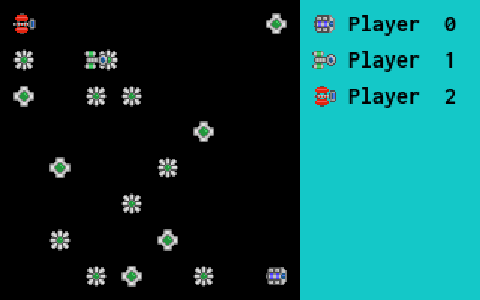

In [4]:
# On utilise le wrapper simple CompassQTable
env = CompassQTable(DeliveryDrones())

# Environnement sans gratte-ciels, ni décharge
env.env_params.update({
    'n_drones': 3,
    'skyscrapers_factor': 0,
    'stations_factor': 0,
    'discharge': 0,
    'rgb_render_rescale': 1.5,
    })

states = env.reset()

print('Observation space:', env.observation_space)
print('Initial state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))

In [5]:
# On crée les agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env,
    gamma=0.95, # Discount factor
    alpha=0.1, # Learning rate
    # Exploration rate
    epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01
)
agents

{0: <agents.qlearning.QLearningAgent at 0x79e461373ca0>,
 1: <agents.random.RandomAgent at 0x79e461373dc0>,
 2: <agents.random.RandomAgent at 0x79e461372440>}

In [9]:
# Entrainement
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(5000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
Training agents: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 1750.35it/s]


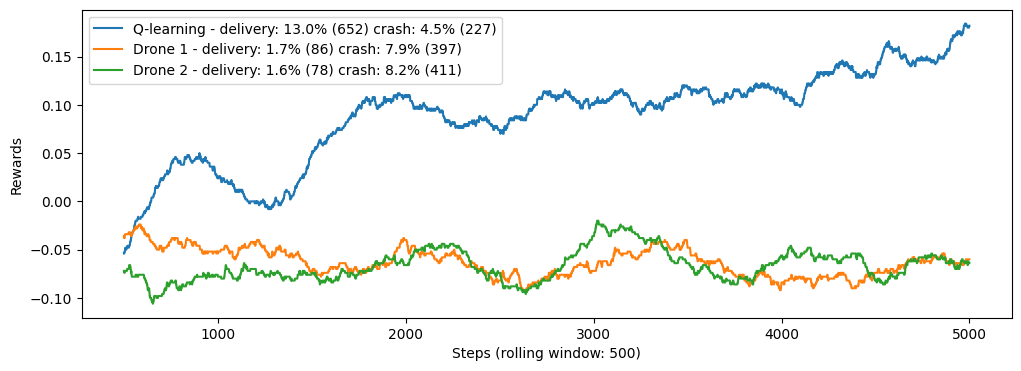

In [10]:
plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'Q-learning'})

In [11]:
agents[0].get_qtable()

,←,↓,→,↑,X
→,1.8,1.4,2.6,1.4,2
↙,1.5,2.5,1.2,0.73,1.3
←,2.9,1.9,1.3,1.3,2.2
↓,1.5,3.2,0.93,0.96,1.8
↖,1.5,0.92,1.2,2.4,1.4
↑,1.1,1.3,1.3,3,1.9
↗,0.68,0.91,2.1,1,1.2
↘,1.2,1.6,2.6,1.5,1.5


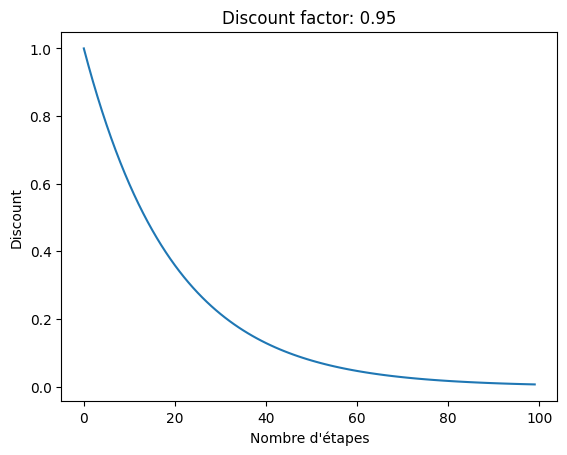

In [12]:
plt.plot(agents[0].gamma**np.arange(100))
plt.title('Discount factor: {}'.format(agents[0].gamma))
plt.xlabel('Nombre d\'étapes')
plt.ylabel('Discount')
plt.show()

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 2143.95it/s]


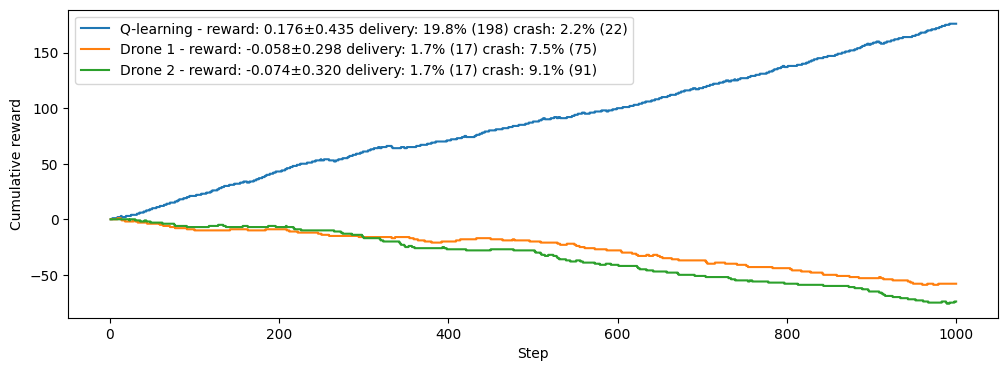

In [15]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'Q-learning'})

In [16]:
path = os.path.join('output', 'videos', 'ql-compass.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   1%|▌                                             | 34/2880 [00:00<00:08, 337.21it/s, now=None]

Moviepy - Building video output/videos/ql-compass.mp4.
Moviepy - Writing video output/videos/ql-compass.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass.mp4


Allons plus loin : Q-table avec Compass et LIDAR
---

Ajoutons à présent des gratte-ciels (skyscrappers), toujours sans décharge, mais avec un détecteur de proximité (LIDAR).

Observation space: Dict(target_dir:Discrete(8), lidar:MultiBinary(8))
Sample state: {0: 'target: ↑, lidar: ↓, →', 1: 'target: ↓, lidar: ↑', 2: 'target: ↗, lidar: →, ↖'}


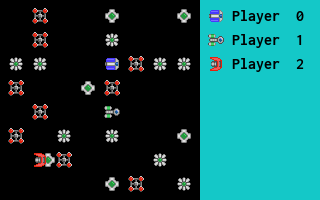

In [17]:
env = LidarCompassQTable(DeliveryDrones())
env.env_params.update({'n_drones': 3, 'skyscrapers_factor': 3, 'stations_factor': 0, 'discharge': 0})
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))

In [18]:
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env,
    gamma=0.95, # Discount factor
    alpha=0.1, # Learning rate
    # Exploration rate
    epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01
)
agents

{0: <agents.qlearning.QLearningAgent at 0x79e450f71690>,
 1: <agents.random.RandomAgent at 0x79e450f70c70>,
 2: <agents.random.RandomAgent at 0x79e450f71810>}

Training agents: 100%|███████████████████████████████████████| 5000/5000 [00:03<00:00, 1426.11it/s]


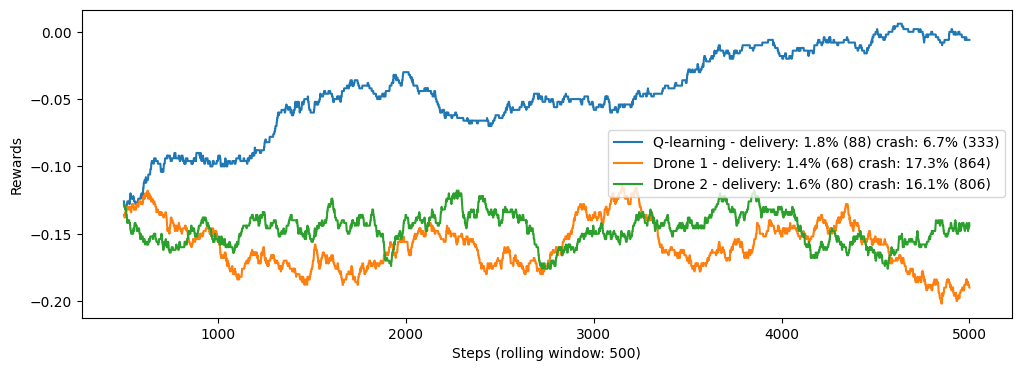

In [19]:
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(5000)
plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'Q-learning'})

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1389.70it/s]


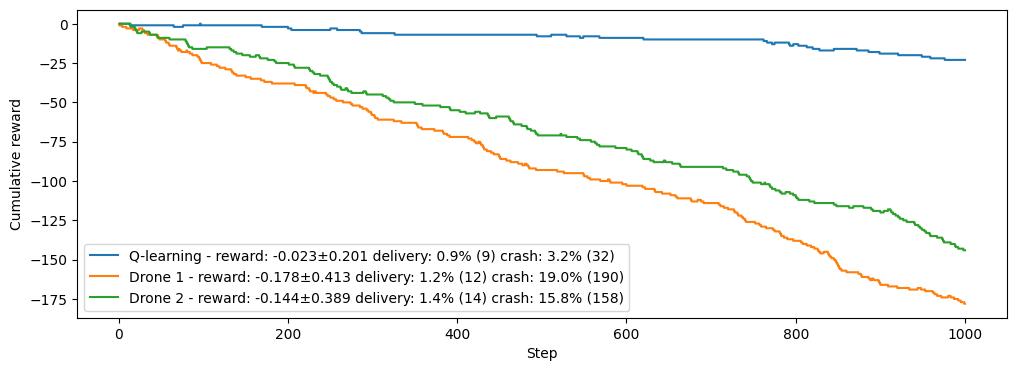

In [20]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'Q-learning'})

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-1st-try.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   2%|▉                                             | 56/2880 [00:00<00:05, 557.25it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-1st-try.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-1st-try.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-1st-try.mp4


Problèmes avec le Q-learning
---

Nous observons deux problèmes :

* Les récompenses sont rares: moins de 1% de "delivery"
* Pas de généralisation : il faut explorer toutes les solutions possibles !

In [21]:
q_table = agents[0].get_qtable()
print('Q-table:', q_table.shape)
q_table.sample(10)

Q-table: (484, 5)


,←,↓,→,↑,X
"target: ↖, lidar: ↙, ↓, ↘, →, ↖",0.3,0.06,0.37,0.43,0.61
"target: ↗, lidar: ↓, →, ↗",0.9,0.5,0.39,0.024,0.6
"target: ↖, lidar: ←, ↘, →, ↗, ↑",0.42,0.38,0.8,0.44,0.18
"target: →, lidar: ↘",0.53,0.73,0.7,0.73,0.51
"target: ↙, lidar: ←, ↓, ↗, ↖",0.54,0.65,0.7,0.62,0.68
"target: ↘, lidar: ↙, ↘, ↗, ↑, ↖",0.55,0.6,0.89,0.77,0.29
"target: ↙, lidar: ←, ↓, ↗, ↑",0.63,0.65,0.7,0.086,0.69
"target: ↘, lidar: ↓, ↗",0.84,0.87,0.27,0.6,0.54
"target: ↖, lidar: ↘",0.7,0.21,0.66,0.7,0.28
"target: ↘, lidar: ←, ↗, ↑, ↖",0.088,0.13,0.52,0.54,0.35


Solutions possibles
---

  deprecation(

Training agents: 100%|█████████████████████████████████████| 30000/30000 [00:23<00:00, 1270.90it/s]


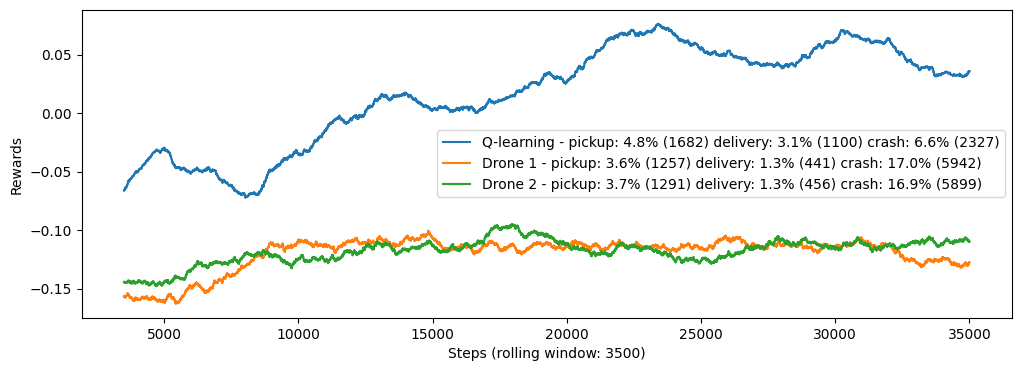

In [22]:
# (1/2) Créer des récompenses intermédiaires : pickup_reward
env.env_params.update({
    'n_drones': 3, 'pickup_reward': 0.99, 'delivery_reward': 1,
    'skyscrapers_factor': 3, 'stations_factor': 0, 'discharge': 0})
states = env.reset()

# (2/2) Entrainer plus longtemps... ..
agents[0].epsilon = 1
agents[0].epsilon_decay = 0.999

set_seed(env, seed=0)
trainer.train(30000)

plot_rolling_rewards(
    trainer.rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'})

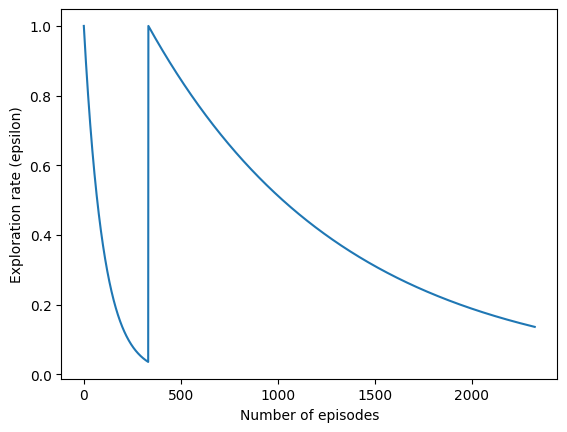

In [23]:
plt.plot(agents[0].epsilons)
plt.xlabel('Number of episodes')
plt.ylabel('Exploration rate (epsilon)')
plt.show()

Testing agents: 100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 790.14it/s]


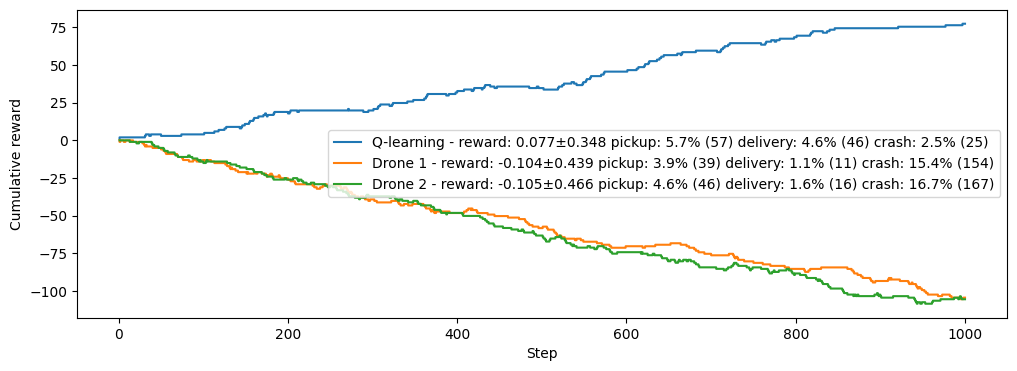

In [24]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'}
)

Risque de sur-entrainement ("overfitting")
---

Pour l'instant, on entraine notre agent que dans un seul environnement. Que ce passe-t-il si on le change ?

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1231.76it/s]


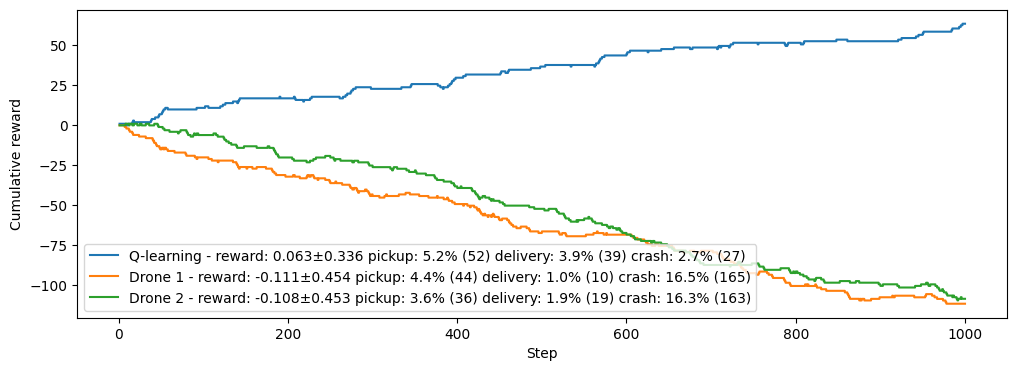

In [25]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=1)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'}
)

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-2nd-try.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=1)
ColabVideo(path)

t:   2%|▊                                             | 53/2880 [00:00<00:05, 526.17it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-2nd-try.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-2nd-try.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-2nd-try.mp4


# Exercice : Entrainez le meilleur agent possible dans cet environnement !

- Validez que votre agent est robuste en l'évaluant dans plusieurs environnements
- Comparez la performance en l'entrainant plus ou moins
- Modifier les différents paramètres : learning rate, discount factor...

    'drone_density': 0.05,
    'n_drones': 3,
    'pickup_reward': 0,
    'delivery_reward': 1,
    'crash_reward': -1,
    'charge_reward': -0.1,
    'discharge': 10,
    'charge': 20,
    'packets_factor': 3,
    'dropzones_factor': 2,
    'stations_factor': 2,
    'skyscrapers_factor': 3,
    'rgb_render_rescale': 1.0

Observation space: Dict(target_dir:Discrete(8), lidar:MultiBinary(8))
Sample state: {1: 'target: ↑, lidar: →, ↑', 0: 'target: ↑, lidar: ↘, ↑', 2: 'target: ←, lidar: →, ↖'}


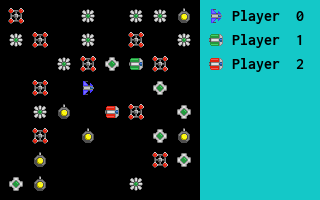

In [47]:
env.env_params.update({
    'drone_density': 0.05,
    'n_drones': 3,
    'pickup_reward': 0,
    'delivery_reward': 1,
    'crash_reward': -1,
    'charge_reward': -0.1,
    'discharge': 0,
    'charge': 20,
    'packets_factor': 3,
    'dropzones_factor': 2,
    'stations_factor': 2,
    'skyscrapers_factor': 3,
    'rgb_render_rescale': 1.0
    })
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))



Observation space: Dict(target_dir:Discrete(8), lidar:MultiBinary(8))
Sample state: {1: 'target: ↑, lidar: ↗', 2: 'target: ↑, lidar: ↙', 0: 'target: →, lidar: ↙, ↓, ↘, ↗'}


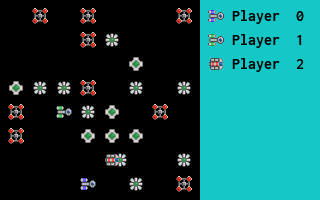

In [53]:
env = LidarCompassQTable(DeliveryDrones())
env.env_params.update({'n_drones': 3, 'skyscrapers_factor': 3, 'stations_factor': 0, 'discharge': 0})
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))

In [54]:
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env,
    gamma=0.95, # Discount factor
    alpha=0.1, # Learning rate
    # Exploration rate
    epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01
)
agents

{0: <agents.qlearning.QLearningAgent at 0x79e44e722c80>,
 1: <agents.random.RandomAgent at 0x79e44f763880>,
 2: <agents.random.RandomAgent at 0x79e44f761e10>}

Training agents: 100%|█████████████████████████████████████| 10000/10000 [00:08<00:00, 1187.55it/s]


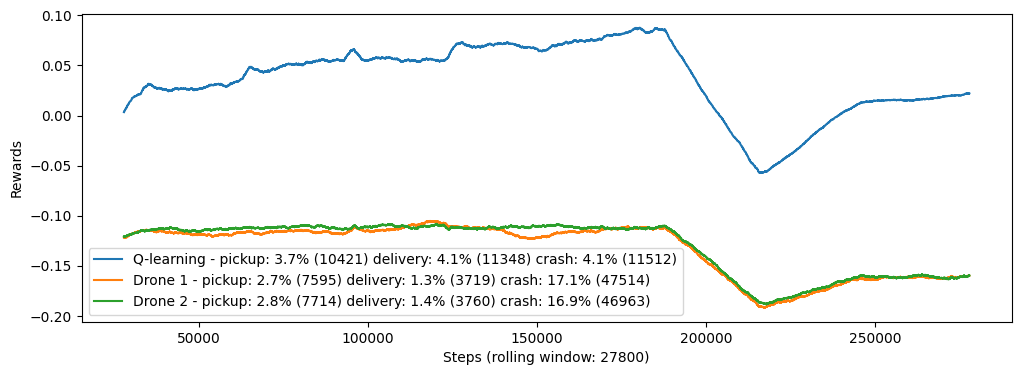

In [55]:
# (2/2) Entrainer plus longtemps... ..
agents[0].epsilon = 1
agents[0].epsilon_decay = 0.99

set_seed(env, seed=0)
trainer.train(10000)

plot_rolling_rewards(
    trainer.rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'})

Limitation du Q-learning: la taille de la Q-table!
---

Essayons maintenant avec l'environnment complet : avec gratte-ciels et décharge

Observation space: Dict(target_dir:Discrete(8), station_dir:Discrete(9), charge_level:Discrete(4), lidar:MultiBinary(8))
Sample state: target: ↘, lidar: ↙, ↖, station: →, charge: 3


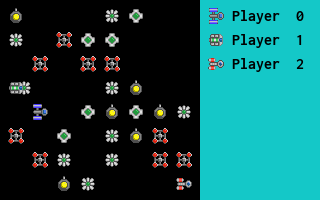

In [56]:
env = LidarCompassChargeQTable(DeliveryDrones())
env.env_params.update({
    'n_drones': 3, 'pickup_reward': 0.99, 'delivery_reward': 1,
    'discharge': 10, 'charge': 20, 'charge_reward': -0.1  # (default values)
})
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', env.format_state(states[0]))
Image.fromarray(env.render(mode='rgb_array'))

Training agents: 100%|██████████████████████████████████████| 35000/35000 [00:35<00:00, 981.47it/s]


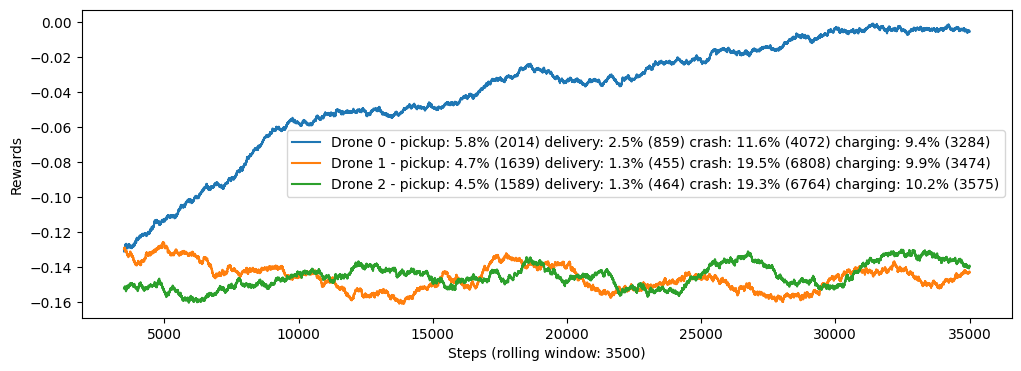

In [57]:
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env, gamma=0.95, alpha=0.1,
    epsilon_start=1, epsilon_decay=0.999, epsilon_end=0.01
)

trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(35000)
plot_rolling_rewards(trainer.rewards_log, events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

In [58]:
q_table = agents[0].get_qtable()
print('Q-table:', q_table.shape)
q_table.sample(10)

Q-table: (4751, 5)


,←,↓,→,↑,X
"target: ↖, lidar: ←, station: ↗, charge: 1",0.15,0.91,0.28,0.88,0.92
"target: →, lidar: ↙, ↘, station: ↗, charge: 0",0.46,0.83,0.16,0.61,0.45
"target: ↖, lidar: ↙, ↓, ↘, ↑, ↖, station: ↑, charge: 2",0.3,0.73,0.84,0.82,0.44
"target: ↓, lidar: →, station: ↘, charge: 3",0.63,0.011,0.74,0.32,0.55
"target: ↙, lidar: ↘, ↑, station: X, charge: 2",0.91,0.33,0.51,0.47,0.37
"target: ↘, lidar: ↓, station: ↗, charge: 1",0.65,0.51,0.098,0.3,0.22
"target: ↗, lidar: ←, →, station: X, charge: 3",0.26,0.018,0.92,0.74,0.62
"target: →, lidar: ↘, station: ↘, charge: 2",0.37,0.21,0.66,0.3,0.46
"target: →, lidar: ←, ↙, ↓, ↘, ↗, ↖, station: ↗, charge: 3",0.65,0.042,0.69,0.13,0.91
"target: ↗, lidar: ↖, station: ↘, charge: 0",0.16,0.92,0.83,0.73,0.5


  deprecation(

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1045.52it/s]


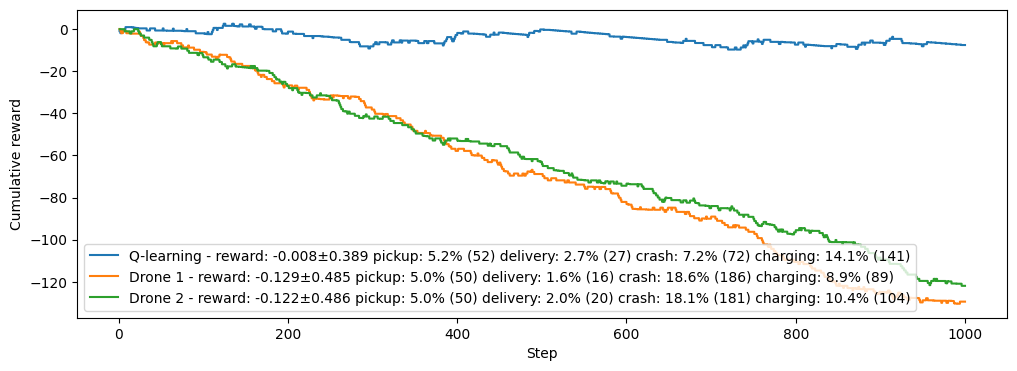

In [59]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]},
    drones_labels={0: 'Q-learning'}
)

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-charge.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   2%|▉                                             | 57/2880 [00:00<00:05, 561.97it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-charge.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-charge.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-charge.mp4


# Pouvez-vous faire mieux ? 💪